In [1]:
# Load VGG19 from Keras
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
             include_top=False,
                  input_shape=(244, 244, 3))

# Display summary of VGG19
conv_base.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
__________

In [3]:

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/aind2/Poverty_prediciton/Collection_figures/figures 6/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'valid')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count, 3) )
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(244, 244),
        batch_size=batch_size,
        class_mode ='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2295)
validation_features, validation_labels = extract_features(test_dir, 1000)
#validation_features, validation_labels = train_features, train_labels
#test_features, test_labels = extract_features(test_dir, 63)


Found 2295 images belonging to 3 classes.
Found 1000 images belonging to 3 classes.


In [4]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(7, 7, 512)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=60,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2295 samples, validate on 1000 samples
Epoch 1/60
2295/2295 [==============================] - 2s - loss: 1.1381 - acc: 0.3821 - val_loss: 1.0303 - val_acc: 0.5300
Epoch 2/60
2295/2295 [==============================] - 1s - loss: 1.0584 - acc: 0.4619 - val_loss: 0.9940 - val_acc: 0.5680
Epoch 3/60
2295/2295 [==============================] - 1s - loss: 1.0111 - acc: 0.5133 - val_loss: 0.9620 - val_acc: 0.5770
Epoch 4/60
2295/2295 [==============================] - 1s - loss: 0.9705 - acc: 0.5481 - val_loss: 0.9403 - val_acc: 0.5800
Epoch 5/60
2295/2295 [==============================] - 1s - loss: 0.9493 - acc: 0.5669 - val_loss: 0.9131 - val_acc: 0.5960
Epoch 6/60
2295/2295 [==============================] - 1s - loss: 0.9212 - acc: 0.5821 - val_loss: 0.8950 - val_acc: 0.6020
Epoch 7/60
2295/2295 [==============================] - 1s - loss: 0.9023 - acc: 0.5887 - val_loss: 0.8955 - val_acc: 0.6040
Epoch 8/60
2295/2295 [==============================] - 1s - loss: 0.8925 - a

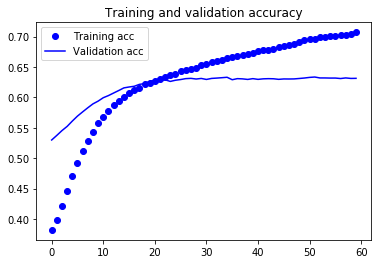

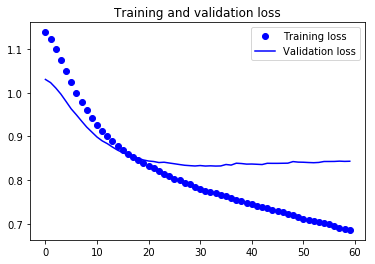

In [5]:
import matplotlib.pyplot as plt

import matplotlib
matplotlib.get_backend()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))


In [7]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 26,447,939
Trainable params: 26,447,939
Non-trainable params: 0
_________________________________________________________________


In [8]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 36


In [9]:
conv_base.trainable = False


In [10]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(244, 244),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(244, 244),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2295 images belonging to 3 classes.
Found 1000 images belonging to 3 classes.
Epoch 1/30
245s - loss: 1.0120 - acc: 0.5125 - val_loss: 0.9652 - val_acc: 0.5770
Epoch 2/30
244s - loss: 0.9044 - acc: 0.5893 - val_loss: 0.8803 - val_acc: 0.6410
Epoch 3/30
241s - loss: 0.8521 - acc: 0.6178 - val_loss: 0.8770 - val_acc: 0.5990
Epoch 4/30
241s - loss: 0.8535 - acc: 0.6122 - val_loss: 0.8674 - val_acc: 0.6270
Epoch 5/30
241s - loss: 0.8283 - acc: 0.6278 - val_loss: 0.7834 - val_acc: 0.6120
Epoch 6/30
241s - loss: 0.8300 - acc: 0.6307 - val_loss: 0.8322 - val_acc: 0.6240
Epoch 7/30
240s - loss: 0.8149 - acc: 0.6447 - val_loss: 0.7893 - val_acc: 0.6500
Epoch 8/30
241s - loss: 0.7959 - acc: 0.6365 - val_loss: 0.7594 - val_acc: 0.6710
Epoch 9/30
240s - loss: 0.8002 - acc: 0.6490 - val_loss: 0.8625 - val_acc: 0.6070
Epoch 10/30
240s - loss: 0.8000 - acc: 0.6257 - val_loss: 0.8470 - val_acc: 0.6450
Epoch 11/30
240s - loss: 0.7747 - acc: 0.6525 - val_loss: 0.7494 - val_acc: 0.6680
Epoch 12/30


In [12]:
model.save('poverty_pred_VGG19_3.h5')

model.save_weights('poverty_pred_VGG19_3_weights.h5')
# from keras.models import load_model 
# from keras.models import load_model 

# model= load_model('poverty_pred_ResNet_3.h5')


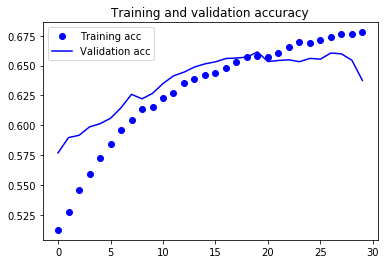

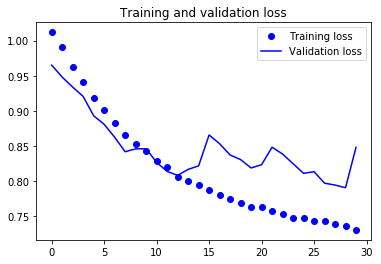

In [13]:
import matplotlib.pyplot as plt

import matplotlib
matplotlib.get_backend()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [4]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [14]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 111s - loss: 0.6351 - acc: 0.7040 - val_loss: 0.8510 - val_acc: 0.6530
Epoch 2/100
100/100 [==============================] - 111s - loss: 0.6286 - acc: 0.7185 - val_loss: 0.8085 - val_acc: 0.6730
Epoch 3/100
100/100 [==============================] - 111s - loss: 0.6055 - acc: 0.7297 - val_loss: 0.9075 - val_acc: 0.6250
Epoch 4/100
100/100 [==============================] - 111s - loss: 0.6213 - acc: 0.7292 - val_loss: 0.8695 - val_acc: 0.6620
Epoch 5/100
100/100 [==============================] - 111s - loss: 0.6023 - acc: 0.7370 - val_loss: 0.9739 - val_acc: 0.6490
Epoch 6/100
100/100 [==============================] - 111s - loss: 0.5816 - acc: 0.7340 - val_loss: 0.9585 - val_acc: 0.6570
Epoch 7/100
100/100 [==============================] - 111s - loss: 0.5924 - acc: 0.7433 - val_loss: 1.0196 - val_acc: 0.6480
Epoch 8/100
100/100 [==============================] - 111s - loss: 0.5888 - acc: 0.7300 - val_loss: 1.0592 - val_acc:

In [16]:
model.save('poverty_pred_VGG19_4.h5')


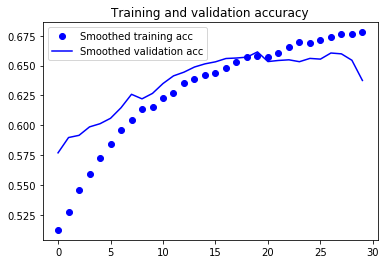

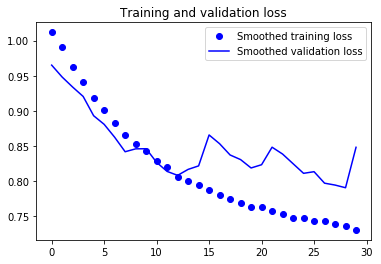

In [17]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(244, 244),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 3 classes.
test acc: 0.621000013947
